In [74]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet101, ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import trange, tqdm
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [75]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [76]:
def load_VASIA(img_folder):
   
    train_data=[]
    test_data=[]
    
    train_label=[]
    test_label=[]
   
    for dir1 in tqdm(os.listdir(img_folder)):
        for eye in os.listdir(os.path.join(img_folder, dir1)):
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [0, 1, 2, 3, 4, 5, 6, 7]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                train_data.append(img)
                train_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in [8, 9]):
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                test_data.append(img)
                test_label.append(dir1+'0' if eye == 'L' else dir1+'1')
                
    return np.array(train_data), np.array(train_label), np.array(test_data), np.array(test_label)

In [77]:
X_train, y_train, X_test, y_test = load_VASIA('Iris-Dataset/CASIA-Iris-Thousand')

  0%|          | 0/1000 [00:00<?, ?it/s]

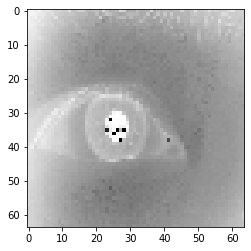

In [78]:
plt.imshow((X_train[0]*255).astype(np.uint8))

In [79]:
def combine_LR(X, y, classes, img_num):
    X_combined = []
    y_combined = []
    for i in range(0, classes*img_num*2, img_num*2):
        for j in range(img_num):
            X_combined.append(np.concatenate((X[i+j], X[i+j+img_num]), axis=1))
            y_combined.append("".join([*y[i]][:3]))
    return np.array(X_combined), np.array(y_combined)

In [80]:
X_train, y_train = combine_LR(X_train, y_train, 1000, 8)
X_test, y_test = combine_LR(X_test, y_test, 1000, 2)

In [81]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [83]:
import sklearn.svm as svm
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import pickle

In [84]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

In [85]:
with tf.device('GPU:0'):
    features_train = model.predict(X_train)
    features_test = model.predict(X_test)

63/63 [==============================] - 1s 22ms/step


In [86]:
clf = svm.SVC(kernel='linear')
clf.fit(features_train.reshape(features_train.shape[0], -1), y_train)

SVC(kernel='linear')

In [87]:
# clf = pickle.load(open('Model/svm_VGG16.pickle', "rb"))

In [88]:
pickle.dump(clf, open('Model/5fold/svm_VGG16_fold5.pickle', 'wb'))

In [89]:
# clf = pickle.load(open('Model/svm_VGG16_fold7.pickle', "rb"))

In [90]:
y_predict_test = clf.predict(features_test.reshape(features_test.shape[0], -1))

In [91]:
accuracy = accuracy_score(y_predict_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 83.20%
